# Import Package

In [1]:
import tensorflow as tf
from  matplotlib import pyplot as plt
import splitfolders
%matplotlib inline

# Split Data

In [2]:
DATA_DIR = 'Dataset'

In [6]:
splitfolders.ratio(DATA_DIR, output='data-split-80-20', seed=42, ratio=(.8, .2,))

Copying files: 8982 files [00:48, 184.32 files/s]


# Generate Data

In [3]:
IMAGE_SHAPE = (300, 300)
TRAINING_DATA_DIR = 'data-split-80-20/train'
VALID_DATA_DIR = 'data-split-80-20/val'

In [4]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)
train_generator = datagen.flow_from_directory(
    TRAINING_DATA_DIR,
    shuffle=True,
    target_size=IMAGE_SHAPE,
)
valid_generator = datagen.flow_from_directory(
    VALID_DATA_DIR,
    shuffle=False,
    target_size=IMAGE_SHAPE,
)

Found 7185 images belonging to 3 classes.
Found 1797 images belonging to 3 classes.


# Build Model

In [7]:
def build_model(num_classes):
    model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', 
                           input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model
model = build_model(num_classes=3)

# Compile Model

In [8]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 298, 298, 8)       224       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 149, 149, 8)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 147, 147, 16)      1168      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 73, 73, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 71, 71, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 35, 35, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 39200)            

In [9]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=2, 
    min_delta=0.001, 
    mode='max'
    )

In [10]:
EPOCHS = 10
BATCH_SIZE = 32
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=valid_generator,
                    validation_steps= valid_generator.samples // BATCH_SIZE,
                    verbose=1,
                    callbacks=[early_stopping]
                    )

Epoch 1/10


c:\Users\ASUS\anaconda3\envs\data-science\lib\site-packages\keras\backend.py:4846: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


224/224 [==============================] - 237s 1s/step - loss: 0.5342 - accuracy: 0.7827 - val_loss: 0.2867 - val_accuracy: 0.9169
Epoch 2/10
224/224 [==============================] - 217s 969ms/step - loss: 0.2636 - accuracy: 0.9095 - val_loss: 0.2158 - val_accuracy: 0.9319
Epoch 3/10
224/224 [==============================] - 215s 957ms/step - loss: 0.2186 - accuracy: 0.9258 - val_loss: 0.1912 - val_accuracy: 0.9358
Epoch 4/10
224/224 [==============================] - 178s 793ms/step - loss: 0.1922 - accuracy: 0.9328 - val_loss: 0.1946 - val_accuracy: 0.9208
Epoch 5/10
224/224 [==============================] - 238s 1s/step - loss: 0.1643 - accuracy: 0.9455 - val_loss: 0.1482 - val_accuracy: 0.9503
Epoch 6/10
224/224 [==============================] - 240s 1s/step - loss: 0.1444 - accuracy: 0.9490 - val_loss: 0.1433 - val_accuracy: 0.9453
Epoch 7/10
224/224 [==============================] - 265s 1s/step - loss: 0.1269 - accuracy: 0.9585 - val_loss: 0.1247 - val_accuracy: 0.9570
E

# Plot History

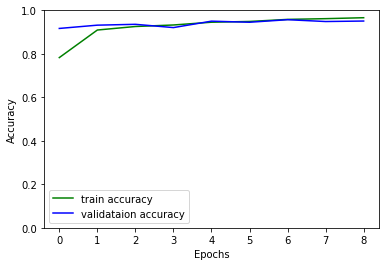

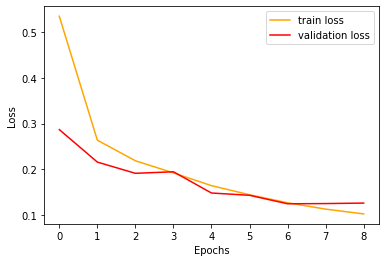

In [11]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']
valid_loss = history.history['val_loss']
valid_acc = history.history['val_accuracy']
def save_plots(train_acc, valid_acc, train_loss, valid_loss):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # accuracy plots
    plt.figure(figsize=(6, 4))
    plt.plot(
        train_acc, color='green', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-', 
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.ylim([0,1])
    plt.savefig('img/accuracy.png')
    
    # loss plots
    plt.figure(figsize=(6, 4))
    plt.plot(
        train_loss, color='orange', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validation loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('img/loss.png')
    plt.show()
save_plots(train_acc, valid_acc, train_loss, valid_loss)

# Save Model

In [14]:
import datetime
model.save(f'{str(datetime.datetime.now())[:10]}-{round(train_acc[len(train_acc)-1]* 100, 2)}_acc.h5')
